# Task 2. Logistic regression as a neural network

**Student**: Anton Konstantinov  
**Group**: C42323

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

### Provided code

In [5]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1./(1.+np.exp(-z))
    
    return s

In [6]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros((dim,1))
    b = 0.
    
    return w, b

In [7]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size which equals the number of features
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    m = X.shape[1]
    #print('number of objects = ',len(X))
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b )                                 # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

Here we add a new parameter `stochastic` which turns SGD on / off. We implement mini-batch SGD with fixed batch size of 50 datapoints.

In [8]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False, stochastic=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    costs = []
    
    for i in range(num_iterations):
        # Cost and gradient calculation
        if stochastic:
            random_idx = np.random.choice(X.shape[1], size=50)
            grads, cost = propagate(w, b, X[:, random_idx], Y[:, random_idx])
        else:
            grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [9]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities 
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1
    
    return Y_prediction

Model is modified to accept a parameter `sgd` which is forwarded to `optimize` function to turn SGD on / off.

In [10]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False, sgd=False):
    """
    Builds the logistic regression model by calling the function we've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array 
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array 
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost, stochastic=sgd)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    train_acc = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
    test_acc = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100
    
    d = {
        "costs": costs,
        "Y_prediction_test": Y_prediction_test, 
        "Y_prediction_train" : Y_prediction_train, 
        "w" : w, 
        "b" : b,
        "learning_rate" : learning_rate,
        "num_iterations": num_iterations,
        "train_acc": train_acc,
        "test_acc": test_acc
    }
    
    return d

### Task

Read the data

In [11]:
df = pd.read_csv('bioresponse.csv')

Separate the dataframe into feature matrix and labels. Split the data into train and test sets.

In [12]:
X = df.drop(columns='Activity')
y = df[['Activity']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)
X_train = X_train.to_numpy().transpose()
X_test = X_test.to_numpy().transpose()
y_train = y_train.to_numpy().transpose()
y_test = y_test.to_numpy().transpose()

Define the learning rate variants to test.

In [13]:
lr_variants = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

Train the model with each learning rate using ordinary gradient descent.

In [14]:
gd_results = []

for lr in lr_variants:
    gd_results.append(model(X_train, y_train,
                            X_test, y_test,
                            num_iterations=10000,
                            learning_rate=lr,
                            sgd=False))

Train the model with each learning rate using mini-batch stochastic gradient descent.

In [15]:
sgd_results = []

for lr in lr_variants:
    sgd_results.append(model(X_train, y_train,
                         X_test, y_test,
                         num_iterations=10000,
                         learning_rate=lr,
                         sgd=True))

Visualize the learning curves for both GD and SGD and for each of the learning rate variants.

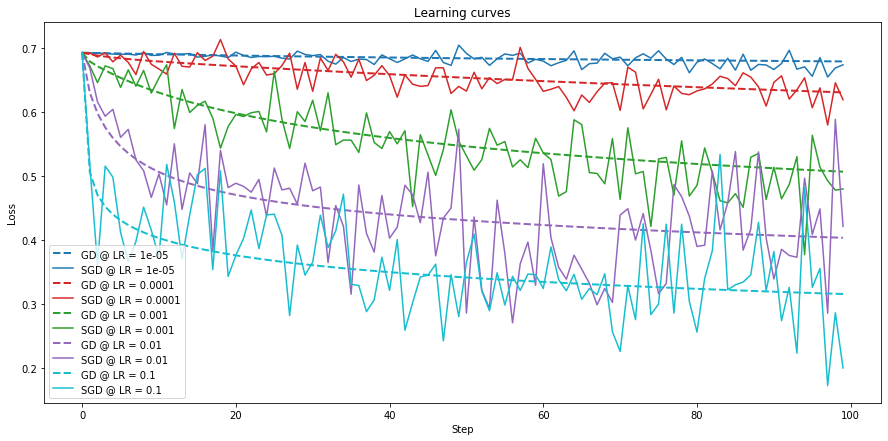

In [17]:
plt.figure(figsize=(15, 7))
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:cyan']
for gd_res, sgd_res, color in zip(gd_results, sgd_results, colors):
    plt.plot(gd_res['costs'], label=f"GD @ LR = {gd_res['learning_rate']}", color=color, linewidth=2, linestyle='dashed')
    plt.plot(sgd_res['costs'], label=f"SGD @ LR = {sgd_res['learning_rate']}", color=color)
plt.title('Learning curves')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

For equal learning rates GD and SGD follow the same trajectory, but SGD graph oscillates wildly due to its stochastic nature.

Visualize the metrics of the trained model for both GD and SGD and for each of the learning rate variants.

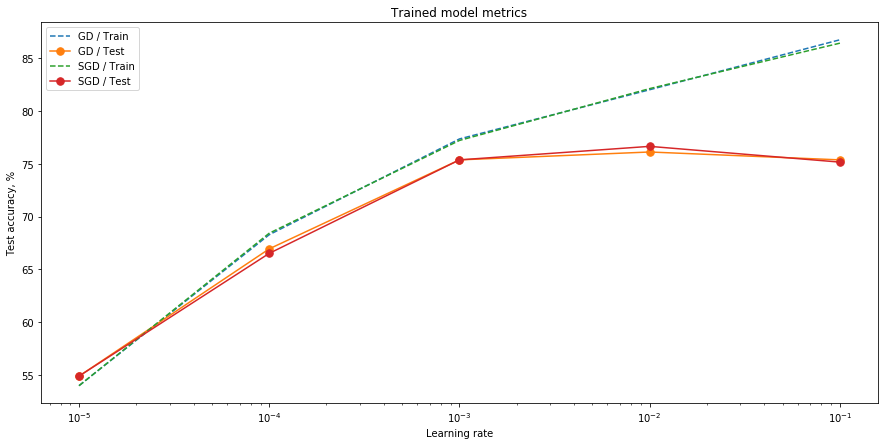

In [18]:
gd_train_accs = [res['train_acc'] for res in gd_results]
gd_test_accs = [res['test_acc'] for res in gd_results]
sgd_train_accs = [res['train_acc'] for res in sgd_results]
sgd_test_accs = [res['test_acc'] for res in sgd_results]

plt.figure(figsize=(15, 7))
plt.plot(lr_variants, gd_train_accs, linestyle='dashed', label='GD / Train')
plt.plot(lr_variants, gd_test_accs, marker='.', markersize=15, label='GD / Test')
plt.plot(lr_variants, sgd_train_accs, linestyle='dashed', label='SGD / Train')
plt.plot(lr_variants, sgd_test_accs, marker='.', markersize=15, label='SGD / Test')

plt.title('Trained model metrics')
plt.xlabel('Learning rate')
plt.ylabel('Test accuracy, %')
plt.xscale('log')
plt.legend()

**Conclusions**:
1. In terms of final performance GD and SGD are equal on this task for all learning rates and with a fixed amount of gradient steps. However, SGD works much faster, because it doesn't iterate over the whole dataset to calculate the gradient for each step;
2. For the **fixed** number of iteration being 10000 in this case, both GD and SGD underfit the data with a small learning rate and overfit it with a large enough learning rate. The optimal learning rate was found to be $10^{-2}$ as it can be seen on the graph. In this case the test performance of the model is the highest. Smaller learning rates would require more steps to reach the same level of performance. Alternatively, we could use learning rate 0.1 and reduce the number of training iterations.